# 📈 ASTP – Projeto Final
## Previsão de atrasos e cancelamentos de voos nos Estados Unidos, com base em fatores meteorológicos

### 👥 Grupo XX
- **Pedro Fonte Santa**, nº 105306  
- **Rafael Alexandre Dias Andorinha**, nº 131000  
- **Vasco Marques**, nº 87526

---

📅 **Data de entrega:** 19 de maio de 2025  

**Objetivo deste Notebook**: Este notebook corresponde ao Objetivo 2 do trabalho. 

Iremos aplicar modelos clássicos de previsão baseados em Alisamento Exponencial (ETS) às séries temporais de Cancelamentos e Atrasos de voos.

A abordagem consiste em:
- Estimar múltiplas variantes do modelo ETS para cada série;
- Selecionar o modelo ótimo com base nos critérios AIC e BIC;
- Avaliar a qualidade do ajuste histórico (in-sample);
- Realizar previsões para o ano de 2022 (Out-of-sample);
- Calcular métricas de erro (MAPE e R²) para o período de janeiro a julho de 2022, validando assim a capacidade preditiva dos modelos.

Este processo visa compreender até que ponto os modelos ETS conseguem capturar os padrões históricos e generalizar para novos períodos.

---

### 🗂️ Datasets:
- [Previsão de estados de Voos (Kaggle)](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022/data?select=raw)  
- [Eventos Climáticos nos EUA (Kaggle)](https://www.kaggle.com/datasets/sobhanmoosavi/us-weather-events/data)


In [1]:
# Imports principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")

import time
start = time.time()

### 📈 1º - Seleção da série de Cancelamentos

Decidimos usar só os dados até 2021 para treinar o modelo, assim conseguimos testar se ele realmente acerta nas previsões com os dados de 2022 que ele nunca viu.

In [2]:
# Leitura dos dados
df = pd.read_csv("../../data/flight-delay-dataset-2018-2022_Final.csv", parse_dates=["FlightDate"])
df = df.set_index("FlightDate")

# Selecionar apenas dados até 2021 para modelar
serie = df.loc[:'2021-12-31', "Cancelamentos"].asfreq('D')  # Série diária

### 1. Aplicação dos 9 Modelos ETS

Testamos todas as combinações possíveis de tendência e sazonalidade. A sazonalidade será testada com `period=7` para padrão semanal e `period=365` para padrão anual. Aqui começamos com sazonalidade semanal (`seasonal_periods=7`).

In [3]:
seasonal_periods = 7  # padrão semanal

resultados_modelos = []

for trend in [None, 'add', 'mul']:
    for seasonal in [None, 'add', 'mul']:
        if trend is None and seasonal is None:
            continue
        try:
            model = ExponentialSmoothing(
                serie,
                trend=trend,
                seasonal=seasonal,
                seasonal_periods=seasonal_periods,
                initialization_method='estimated'
            ).fit()
            resultados_modelos.append({
                'Modelo': f'ETS({trend or "None"},{seasonal or "None"})',
                'AIC': model.aic,
                'BIC': model.bic,
                'modelo_estimado': model
            })
        except Exception as e:
            print(f"Erro no modelo ETS({trend},{seasonal}): {e}")
            continue

df_modelos = pd.DataFrame(resultados_modelos).sort_values(by='AIC').reset_index(drop=True)
df_modelos[['Modelo', 'AIC', 'BIC']]

,Modelo,AIC,BIC
0,"ETS(mul,None)",17361.059202,17382.206708
1,"ETS(None,add)",17391.314100,17438.895987
2,"ETS(add,None)",17408.054852,17429.202358
3,"ETS(add,add)",17454.687090,17512.842730
4,"ETS(mul,add)",17525.003578,17583.159219
5,"ETS(mul,mul)",17638.901455,17697.057095
6,"ETS(None,mul)",17727.671247,17775.253135
7,"ETS(add,mul)",17850.194772,17908.350412


### 2. Comparação dos Modelos: AIC e BIC

Visualizamos os critérios AIC e BIC para os 9 modelos testados.

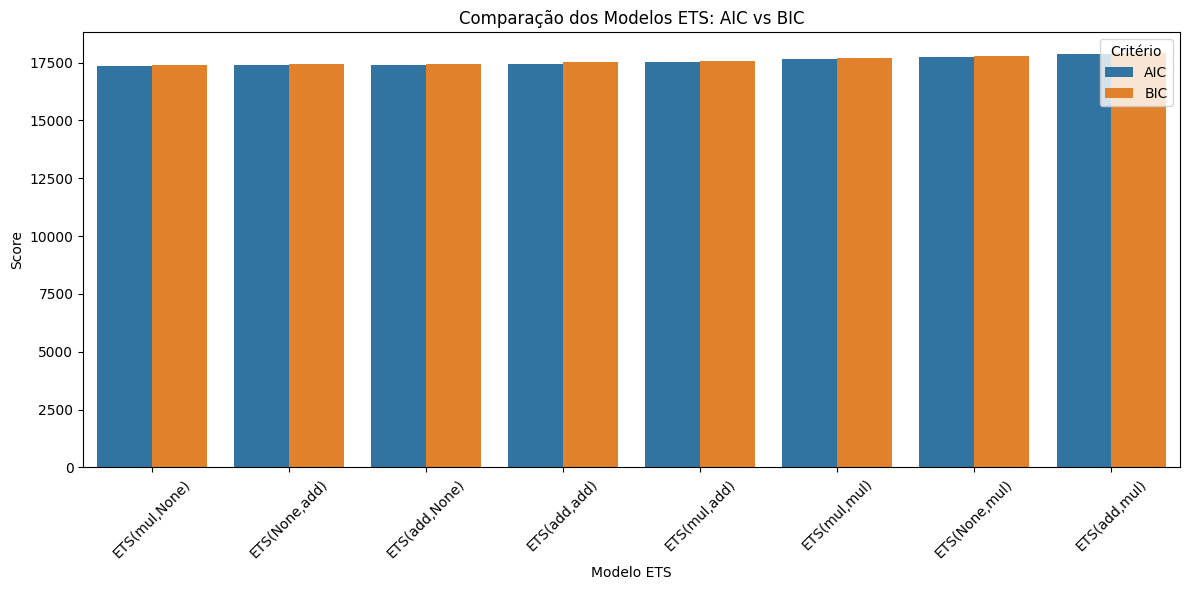

In [4]:
# Reestrutura os dados para formato "long"
df_long = pd.melt(df_modelos[['Modelo', 'AIC', 'BIC']], id_vars='Modelo', 
                  value_vars=['AIC', 'BIC'], var_name='Critério', value_name='Valor')

# Gráfico com barras lado a lado
plt.figure(figsize=(12, 6))
sns.barplot(data=df_long, x='Modelo', y='Valor', hue='Critério')
plt.xticks(rotation=45)
plt.title('Comparação dos Modelos ETS: AIC vs BIC')
plt.ylabel('Score')
plt.xlabel('Modelo ETS')
plt.tight_layout()
plt.show()

### Gráfico de barras e com um pouco de Zoom

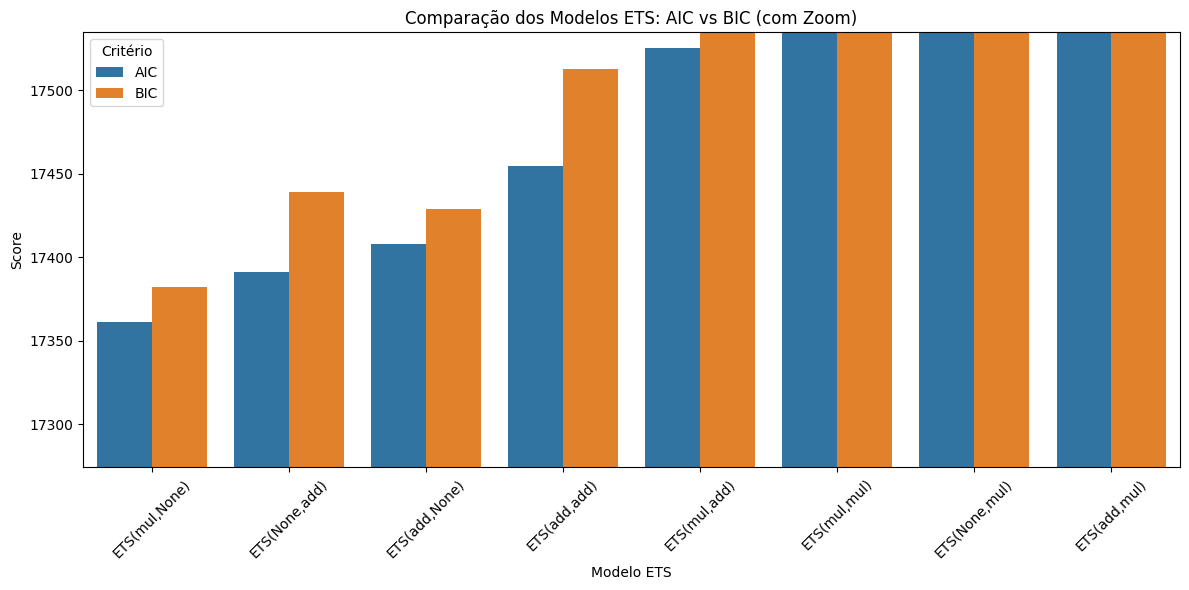

In [5]:
# Reestrutura os dados para formato "long"
df_long = pd.melt(df_modelos[['Modelo', 'AIC', 'BIC']], id_vars='Modelo', 
                  value_vars=['AIC', 'BIC'], var_name='Critério', value_name='Valor')

# Zoom automático: calcula o intervalo de valores e define limites com mais foco
ymin = df_long['Valor'].min() * 0.995
ymax = df_long['Valor'].min() * 1.01  # apenas um pouco acima do mínimo

# Gráfico de barras e com um pouco de Zoom
plt.figure(figsize=(12, 6))
sns.barplot(data=df_long, x='Modelo', y='Valor', hue='Critério')
plt.xticks(rotation=45)
plt.title('Comparação dos Modelos ETS: AIC vs BIC (com Zoom)')
plt.ylabel('Score')
plt.xlabel('Modelo ETS')
plt.ylim(ymin, ymax)
plt.tight_layout()
plt.show()

### 3. Estimação do Melhor Modelo

Selecionámos o modelo com menor AIC e BIC e analisámos os seus parâmetros, ou seja o modelo **ETS(mul,None)**.

In [6]:
melhor_modelo_info = df_modelos.iloc[0]
melhor_modelo = melhor_modelo_info['modelo_estimado']

print(f"Melhor Modelo: {melhor_modelo_info['Modelo']}")
print("\nParâmetros do Modelo:")
print(melhor_modelo.params)


Melhor Modelo: ETS(mul,None)

Parâmetros do Modelo:
{'smoothing_level': 0.8535714285714285, 'smoothing_trend': 0.0001, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 857.6666666666661, 'initial_trend': 0.9509733950464616, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### 4. Avaliação do Ajuste (In-Sample)

Treinámos com dados até 2021, prevemos para 2022 inteiro, e avaliámos a precisão da previsão usando MAPE e R² nos meses de janeiro a julho (período para o qual temos dados reais).

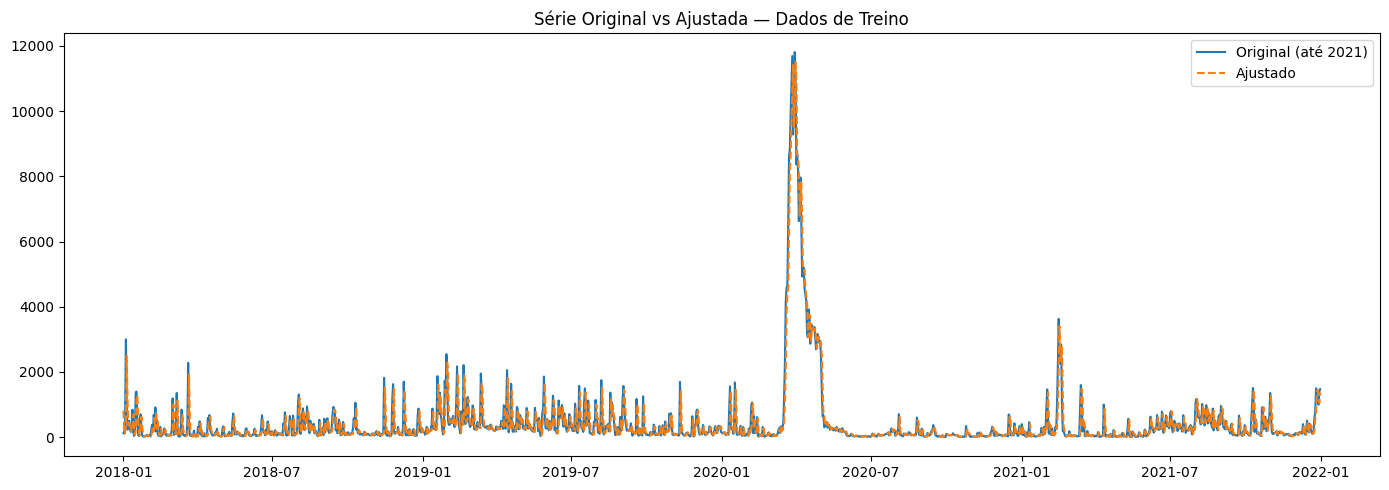

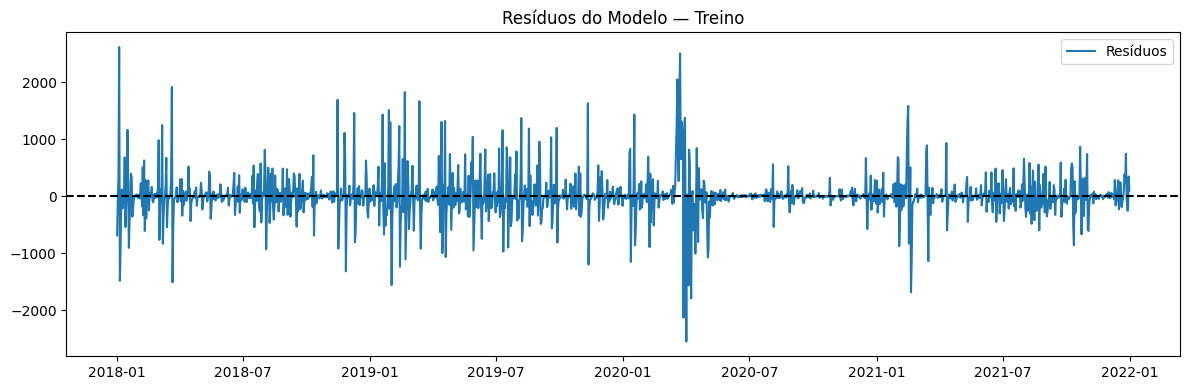

Erro de Ajuste (in-sample):
  MAPE: 88.44%
  R²  : 0.8851


In [7]:
# Série ajustada (apenas treino)
serie_ajustada = melhor_modelo.fittedvalues
residuos = serie - serie_ajustada

plt.figure(figsize=(14,5))
plt.plot(serie, label='Original (até 2021)')
plt.plot(serie_ajustada, label='Ajustado', linestyle='--')
plt.title('Série Original vs Ajustada — Dados de Treino')
plt.legend()
plt.tight_layout()
plt.show()

# Resíduos
plt.figure(figsize=(12,4))
plt.plot(residuos, label='Resíduos')
plt.axhline(0, color='black', linestyle='--')
plt.title('Resíduos do Modelo — Treino')
plt.legend()
plt.tight_layout()
plt.show()

# Estatísticas dos resíduos (in-sample)
mape_in = mean_absolute_percentage_error(serie, serie_ajustada) * 100
r2_in = r2_score(serie, serie_ajustada)

print(f"Erro de Ajuste (in-sample):")
print(f"  MAPE: {mape_in:.2f}%")
print(f"  R²  : {r2_in:.4f}")

### 5. Previsão de Cancelamentos para 2022

In [8]:
# Previsão de 365 dias (2022)
n_dias_2022 = 365
forecast_2022 = melhor_modelo.forecast(n_dias_2022)
forecast_2022.index = pd.date_range(start='2022-01-01', periods=n_dias_2022, freq='D')

### 6. Avaliação da Previsão (Out-of-sample) — Jan-Jul 2022

In [9]:
# Valores reais disponíveis em 2022
serie_real_2022 = df.loc['2022-01-01':'2022-07-31', "Cancelamentos"].asfreq('D')

# Cortar a previsão para o período em que temos dados reais
forecast_avaliacao = forecast_2022.loc['2022-01-01':'2022-07-31']

# Erros: MAPE e R²
mape = mean_absolute_percentage_error(serie_real_2022, forecast_avaliacao) * 100
r2 = r2_score(serie_real_2022, forecast_avaliacao)

print(f"MAPE (Jan-Jul 2022): {mape:.2f}%")
print(f"R² (Jan-Jul 2022): {r2:.4f}")

MAPE (Jan-Jul 2022): 5898.05%
R² (Jan-Jul 2022): -692.0879


### 7. Gráfico da Previsão vs Real (Jan-Jul 2022)

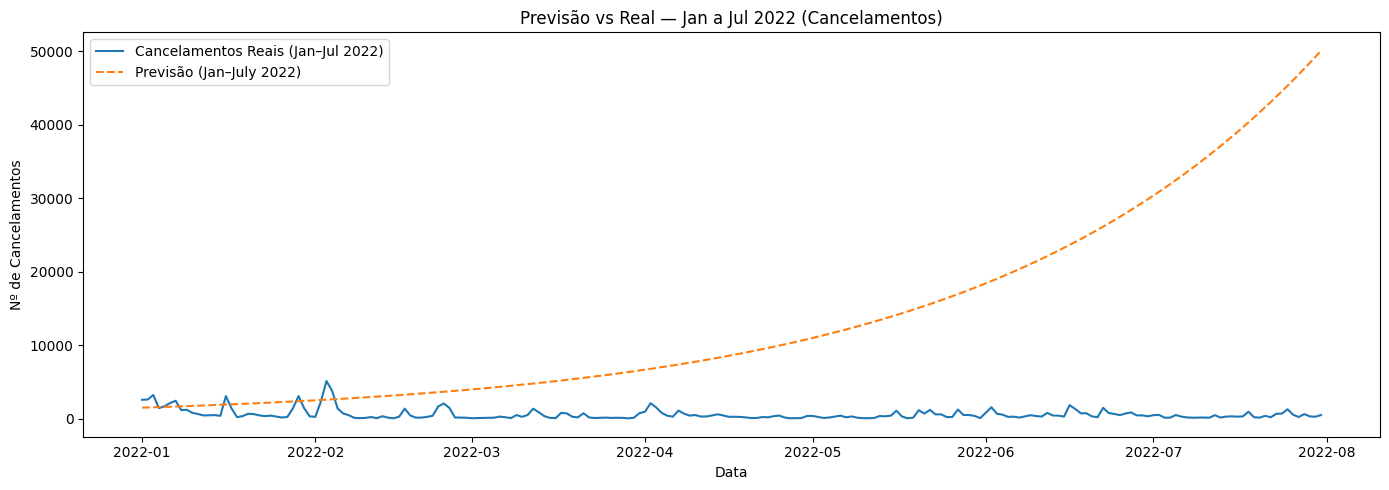

In [10]:
plt.figure(figsize=(14, 5))
plt.plot(serie_real_2022, label='Cancelamentos Reais (Jan–Jul 2022)')
plt.plot(forecast_avaliacao, label='Previsão (Jan–July 2022)', linestyle='--')
plt.title('Previsão vs Real — Jan a Jul 2022 (Cancelamentos)')
plt.xlabel('Data')
plt.ylabel('Nº de Cancelamentos')
plt.legend()
plt.tight_layout()
plt.show()


### 📈 2º - Seleção da série de Atrasos

Foi feito o mesmo processo de seleção dos dados até 2021 para a 2ª serie.

In [11]:
# Leitura dos dados
df = pd.read_csv("../../data/flight-delay-dataset-2018-2022_Final.csv", parse_dates=["FlightDate"])
df = df.set_index("FlightDate")

# Série de Atrasos (dados até 2021)
serie_treino = df.loc[:'2021-12-31', "Atrasos"].asfreq('D')

### 1. Aplicação dos 9 Modelos ETS

In [12]:
# Definir sazonalidade semanal
seasonal_periods = 7  # semanal

resultados_modelos = []

for trend in [None, 'add', 'mul']:
    for seasonal in [None, 'add', 'mul']:
        if trend is None and seasonal is None:
            continue
        try:
            model = ExponentialSmoothing(
                serie_treino,
                trend=trend,
                seasonal=seasonal,
                seasonal_periods=seasonal_periods,
                initialization_method='estimated'
            ).fit()
            resultados_modelos.append({
                'Modelo': f'ETS({trend or "None"},{seasonal or "None"})',
                'AIC': model.aic,
                'BIC': model.bic,
                'modelo_estimado': model
            })
        except Exception as e:
            print(f"Erro no modelo ETS({trend},{seasonal}): {e}")
            continue

# Criar DataFrame com os resultados
df_modelos = pd.DataFrame(resultados_modelos).sort_values(by='AIC').reset_index(drop=True)
df_modelos[['Modelo', 'AIC', 'BIC']]

,Modelo,AIC,BIC
0,"ETS(mul,mul)",19790.379076,19848.534717
1,"ETS(None,mul)",19796.934620,19844.516508
2,"ETS(mul,add)",19819.462766,19877.618406
3,"ETS(None,add)",19821.314219,19868.896106
4,"ETS(add,add)",19844.206812,19902.362452
5,"ETS(add,mul)",19845.987848,19904.143489
6,"ETS(add,None)",20078.547407,20099.694912
7,"ETS(mul,None)",20084.422921,20105.570426


### 2. Comparação dos Modelos: AIC e BIC (com zoom)

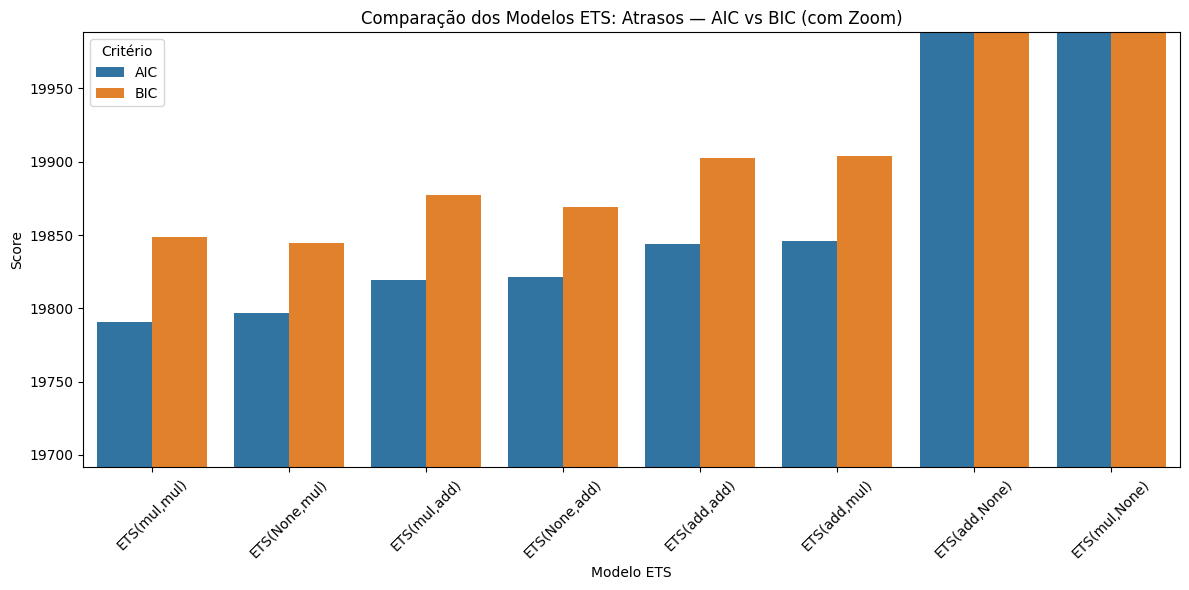

In [13]:
# Long format para barras lado a lado
df_long = pd.melt(df_modelos[['Modelo', 'AIC', 'BIC']], id_vars='Modelo', 
                  value_vars=['AIC', 'BIC'], var_name='Critério', value_name='Valor')

# Zoom automático no topo das barras
ymin = df_long['Valor'].min() * 0.995
ymax = df_long['Valor'].min() * 1.01

plt.figure(figsize=(12, 6))
sns.barplot(data=df_long, x='Modelo', y='Valor', hue='Critério')
plt.xticks(rotation=45)
plt.title('Comparação dos Modelos ETS: Atrasos — AIC vs BIC (com Zoom)')
plt.ylabel('Score')
plt.xlabel('Modelo ETS')
plt.ylim(ymin, ymax)
plt.tight_layout()
plt.show()

### 3. Estimação do Melhor Modelo

>Optou-se pela escolha do modelo **ETS(None, mul)** em função do **ETS(mul, mul)**, apesar deste último apresentar um AIC ligeiramente inferior. A decisão baseou-se no facto de o BIC — critério que penaliza mais fortemente a complexidade do modelo — ser mais favorável no **ETS(None, mul)**.

In [14]:
melhor_modelo_info = df_modelos.iloc[1]
melhor_modelo = melhor_modelo_info['modelo_estimado']

print(f"Melhor Modelo: {melhor_modelo_info['Modelo']}")
print("\nParâmetros do Modelo:")
print(melhor_modelo.params)

Melhor Modelo: ETS(None,mul)

Parâmetros do Modelo:
{'smoothing_level': 0.5471428417008319, 'smoothing_trend': nan, 'smoothing_seasonal': 0.06469388702659343, 'damping_trend': nan, 'initial_level': 3513.5237990985033, 'initial_trend': nan, 'initial_seasons': array([1.36079852, 1.12820493, 1.23560298, 1.15958722, 1.3456659 ,
       0.88016054, 1.10851443]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### 4. Avaliação do Ajuste (In-Sample) — Atrasos

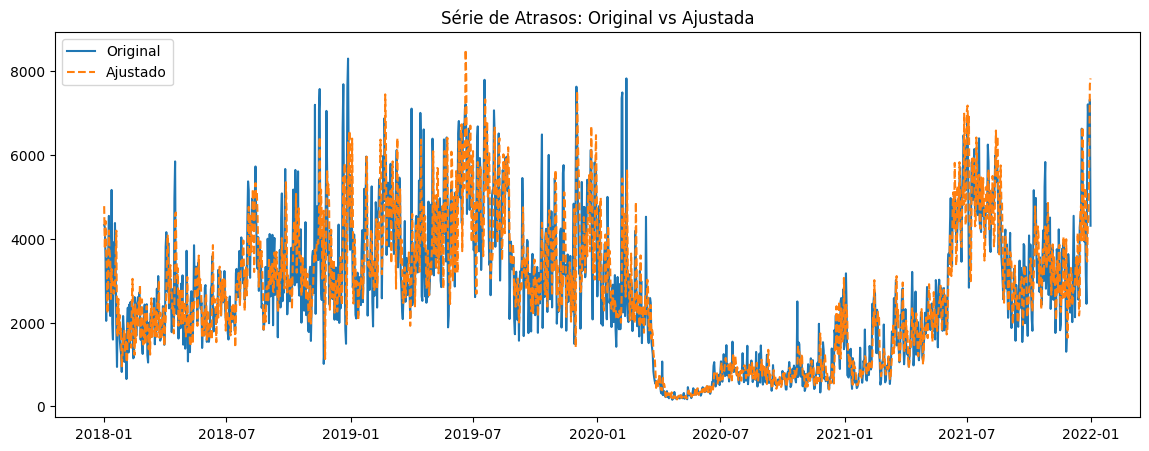

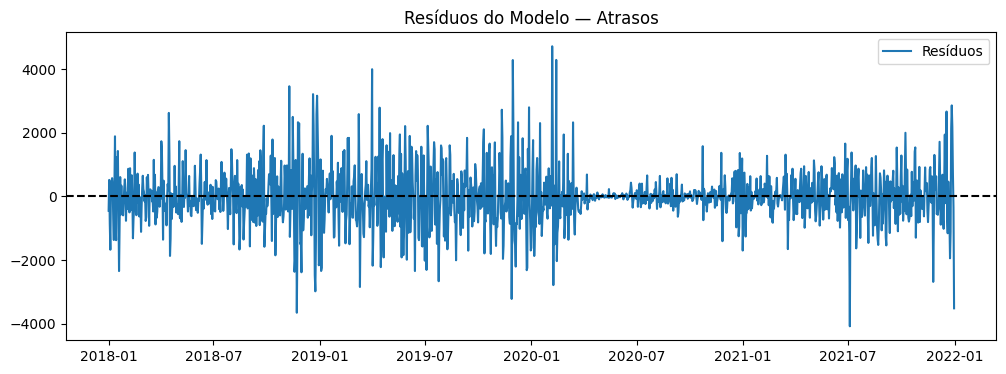

Erro de Ajuste (in-sample):
  MAPE: 23.83%
  R²  : 0.7336


In [15]:
serie_ajustada = melhor_modelo.fittedvalues
residuos = serie_treino - serie_ajustada

plt.figure(figsize=(14,5))
plt.plot(serie_treino, label='Original')
plt.plot(serie_ajustada, label='Ajustado', linestyle='--')
plt.title('Série de Atrasos: Original vs Ajustada')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(residuos, label='Resíduos')
plt.axhline(0, color='black', linestyle='--')
plt.title('Resíduos do Modelo — Atrasos')
plt.legend()
plt.show()

# Estatísticas dos resíduos (in-sample)
mape_in = mean_absolute_percentage_error(serie_treino, serie_ajustada) * 100
r2_in = r2_score(serie_treino, serie_ajustada)

print(f"Erro de Ajuste (in-sample):")
print(f"  MAPE: {mape_in:.2f}%")
print(f"  R²  : {r2_in:.4f}")

### 5. Previsão da Série de Atrasos para 2022

In [16]:
n_dias_2022 = 365
forecast_2022 = melhor_modelo.forecast(n_dias_2022)
forecast_2022.index = pd.date_range(start='2022-01-01', periods=n_dias_2022, freq='D')

### 6. Avaliação da Previsão (Out-of-sample) — Jan-Jul 2022

In [17]:
# Dados reais disponíveis
serie_real_2022 = df.loc['2022-01-01':'2022-07-31', "Atrasos"].asfreq('D')
forecast_avaliacao = forecast_2022.loc['2022-01-01':'2022-07-31']

mape = mean_absolute_percentage_error(serie_real_2022, forecast_avaliacao) * 100
r2 = r2_score(serie_real_2022, forecast_avaliacao)

print(f"MAPE (Jan-Jul 2022) — Atrasos: {mape:.2f}%")
print(f"R² (Jan-Jul 2022) — Atrasos: {r2:.4f}")

MAPE (Jan-Jul 2022) — Atrasos: 52.73%
R² (Jan-Jul 2022) — Atrasos: -1.0551


### 7. Gráfico Previsão vs Real — Série de Atrasos (Jan-Jul 2022)

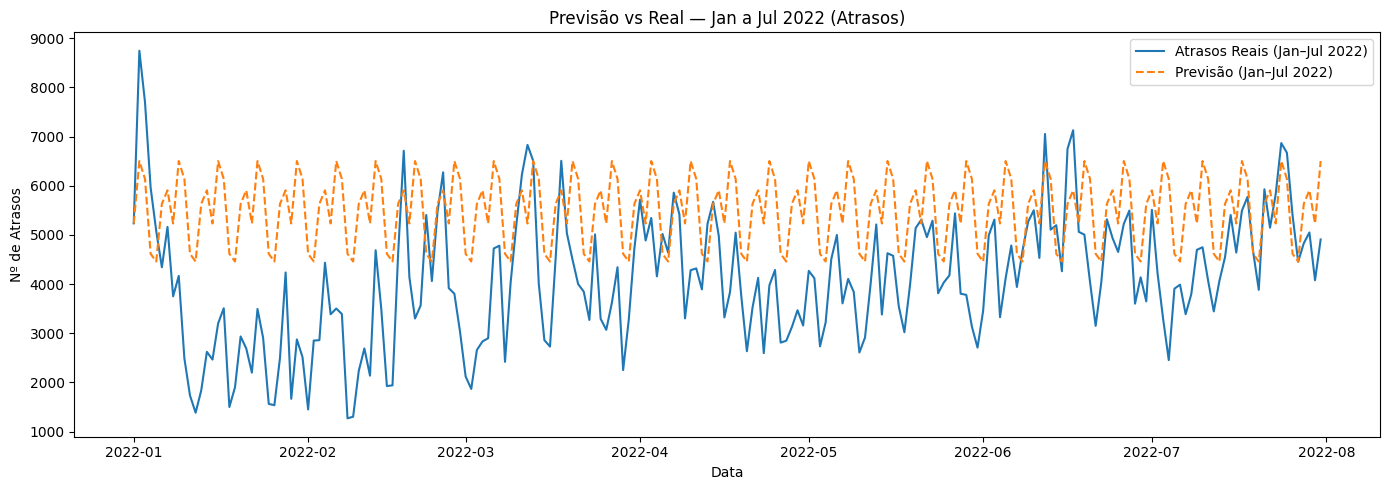

In [18]:
plt.figure(figsize=(14, 5))
plt.plot(serie_real_2022, label='Atrasos Reais (Jan–Jul 2022)')
plt.plot(forecast_avaliacao, label='Previsão (Jan–Jul 2022)', linestyle='--')
plt.title('Previsão vs Real — Jan a Jul 2022 (Atrasos)')
plt.xlabel('Data')
plt.ylabel('Nº de Atrasos')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
end = time.time()
print(f" Tempo total de execução: {end - start:.2f} segundos")

⏱️ Tempo total de execução: 3.18 segundos


### Tabela de Resultados — Modelos de Alisamento Exponencial

#### 📌 Série dos Cancelamentos

| Modelo        | AIC          | BIC          | MAPE (ajuste) | R² (ajuste) | MAPE (previsão) | R² (previsão) |
|---------------|--------------|--------------|----------------|--------------|------------------|----------------|
| ETS(mul,None) | 17,361.06    | 17,382.21    | 88.44%         | 0.8851       | 5,898.05%        | -692.088       |

#### 📌 Série dos Atrasos

| Modelo        | AIC          | BIC          | MAPE (ajuste) | R² (ajuste) | MAPE (previsão) | R² (previsão) |
|---------------|--------------|--------------|----------------|--------------|------------------|----------------|
| ETS(None,mul)  | 19,796.93    | 19,844.52   | 23.83%    | 0.7336      | 52.73%           | -1.0551        |


## Discussão e Interpretação dos Resultados

Após a aplicação dos modelos de Alisamento Exponencial (ETS) às séries de Cancelamentos e Atrasos, foram selecionados os modelos mais adequados com base numa combinação de critérios quantitativos (AIC e BIC) e qualitativos (análise visual e desempenho preditivo).

Para a série de Cancelamentos, o modelo selecionado foi o ETS(mul, None). Embora o R² indique que o modelo explica cerca de 88.5% da variância da série (R² = 0.8851), o MAPE de 88.44% revela que os valores ajustados estão, em média, bastante afastados dos valores reais. O seu desempenho na previsão para 2022 revelou-se extremamente fraco também, com um MAPE de 5.898,05% e um R² de -692.088. Este valor extremamente elevado de MAPE é explicado pelo facto de os cancelamentos em 2022 terem sido muito baixos ou mesmo nulos em vários períodos. Como o MAPE é uma métrica percentual, qualquer desvio — mesmo pequeno — face a valores reais próximos de zero, resulta em erros percentuais desproporcionalmente elevados. Ou seja, o modelo capta bem a forma geral da série, mas comete erros elevados em termos absolutos, o que limita a sua utilidade prática mesmo durante o período de treino.

Já na série de **Atrasos**, foi testado inicialmente o modelo **ETS(mul, mul)**, mas optou-se por substituí-lo pelo **ETS(None, mul)**. Esta decisão foi sustentada por um BIC mais favorável e, acima de tudo, por uma melhoria clara na capacidade preditiva. O modelo ETS(None, mul) apresentou um desempenho de ajuste consistente (MAPE = 23.83%, R² = 0.7336) e, apesar de ainda revelar limitações na previsão (MAPE = 52.73%, R² = -1.0551), superou significativamente o modelo anterior. Isto mostra que, embora os atrasos também apresentem variação, possuem uma estrutura mais estável que permite um modelo ligeiramente mais robusto.

Em suma, os modelos ETS mostraram-se úteis para ajustar os padrões históricos, mas pouco eficazes para prever mudanças abruptas, como as ocorridas em 2022. Estes resultados sublinham a necessidade de explorar abordagens mais avançadas e flexíveis — como modelos ARIMA com intervenção ou redes neurais — que possam capturar estruturas complexas e responder a variações súbitas nos dados. Essa será a próxima etapa a ser desenvolvida no âmbito deste projeto.